In [22]:
import json
import networkx as nx
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import os

#### steps 
1. bulid the network
2. read the text file and compute the similarity between text
3. add the weight to network
4. community detection

In [23]:
# bulid the network 

nodes_edges_json_file = './data/nodes_egdes_new.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)

print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

G_undirect = G.to_undirected()

print('undirected')
print('number of nodes in network:{}'.format(len(G_undirect.nodes())))
print('number of links in network:{}'.format(len(G_undirect.edges())))

number of nodes in network:3705
number of links in network:16120
undirected
number of nodes in network:3705
number of links in network:11942


不知道为啥一直跑不出来。用一下霍格沃兹的子网络试一下？


In [24]:
hogwarts = './data/hogwarts_house.json'
with open(hogwarts,'r') as f:
    hogwarts = json.load(f)

character_hogwarts = []
for house in hogwarts:
    for cha in hogwarts[house]:
        name = cha.replace(' ','_')
        character_hogwarts.append(name)
        
print(len(character_hogwarts))

983


In [25]:
# get the subgragh
G_Hogwarts = G_undirect.subgraph(character_hogwarts)
# basic stat
print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts.nodes())))
print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts.edges())))

number of nodes in Hogwarts network:957
number of links in Hogwarts network:3641


2. read the text file and compute the similarity between text

In [26]:
data_dir = './data/cha_fandom_page_text/'
def clean_text(doc):
    ws = open(data_dir + doc, 'r', encoding='UTF-8').read()
    ws = ws.translate(str.maketrans('', '', '"#$%&\()*+,-/:;<=>@[\\]^_`{|}~.!?')) # remove punctuations               
    ws = nltk.word_tokenize(ws)  
    ws = [w.lower() for w in ws if not w in stopwords.words('english')] 
    return ws



In [36]:
# data_dir = './data/cha_fandom_page_text/'
docLabels = [f for f in G_Hogwarts.nodes()]
# print(len(docLabels))
# save_folder = './data/cha_word_list_fandom/'

# data = []
# for doc in tqdm(docLabels):
#     doc = doc+'.txt'
#     word_list = clean_text(doc)
#     with open(os.path.join(save_folder,doc),'w') as f:
#         json.dump(word_list,f)
#     data.append(word_list)
# print(len(data))

In [37]:
# with open('./data/fandom_text_all.json','w') as f:
#     json.dump(data,f)

In [38]:
# get the data 
word_list_each = []
folder = './data/cha_word_list_fandom/'
for node in G_Hogwarts.nodes():
    file_path = os.path.join(folder,node+'.txt')
    with open(file_path,'r') as f:
        data_ = json.load(f)
    data_ = list(data_)
    word_list_each.append(data_)


In [39]:
# gee the sparse matrix
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity

word_dictionary = Dictionary(word_list_each)
num_feature = len(word_dictionary.token2id)
print(num_feature)
# based on the dict we got, transfer the word_vec to be corpus sets
corpus = [word_dictionary.doc2bow(text) for text in word_list_each]
# build the tf-idf model, then input it  into the corpus sets for training
tfidf = TfidfModel(corpus)
# to handle the text by the usage of tf-idf model
tf_texts = tfidf[corpus] 
# build the similiarity matrix which will be used for caculating simularities between  characters
# num_features = 500
sparse_matrix = SparseMatrixSimilarity(tf_texts, num_feature)

25752


In [31]:
sparse_matrix

In [32]:
character_2 = 'Sirius_Black'
doc_name= character_2+'.txt'
keywords = clean_text(doc_name)
kw_vector = word_dictionary.doc2bow(keywords)
tf_kw = tfidf[kw_vector]

In [33]:
similarities = sparse_matrix.get_similarities(tf_kw)

In [34]:
def caculate_similarity(character,isOwntxt = 0): # is your own input text or not
    if isOwntxt == 0:
        doc_name= character+'.txt'
        keywords = clean_text(doc_name)
    else:
        print('wrong')
    kw_vector = word_dictionary.doc2bow(keywords)
    tf_kw = tfidf[kw_vector]
    similarities = sparse_matrix.get_similarities(tf_kw)
    similarity_dict = {}
    for e, s in enumerate(similarities, 1):
        name = docLabels[e-1]
        similarity_dict[name] = s
        
    similarity_dict= dict(sorted(similarity_dict.items(), key=lambda item:item[1], reverse = True))
    return similarity_dict

In [45]:

weights = {}
for node in G_Hogwarts.nodes():
    # calculate the similrity with 'node'
    simi_dict = caculate_similarity(node)
    
    edges = G_Hogwarts.edges(node)
    print('{}:{}'.format(node,edges))
    weights[node] = {}
    for e in edges:
        
        node2 = e[1]
        print(node2)
        # calculate the 
        simi = simi_dict[node2]
        weights[node][node2] = simi_dict[node2]
        

Seventh_Floor_Gryffindor_Prefect:[('Seventh_Floor_Gryffindor_Prefect', 'Harry_Potter'), ('Seventh_Floor_Gryffindor_Prefect', 'Draco_Malfoy')]
Harry_Potter
Draco_Malfoy
Emily_Tyler:[('Emily_Tyler', 'Albus_Dumbledore'), ('Emily_Tyler', 'Barnaby_Lee'), ('Emily_Tyler', 'Elora_Dunn'), ('Emily_Tyler', 'Emily_Taylor'), ('Emily_Tyler', 'Penny_Haywood'), ('Emily_Tyler', 'Ismelda_Murk'), ('Emily_Tyler', 'Jae_Kim'), ('Emily_Tyler', 'Tulip_Karasu'), ('Emily_Tyler', 'Pansy_Parkinson'), ('Emily_Tyler', 'William_Weasley'), ('Emily_Tyler', 'Nymphadora_Tonks')]
Albus_Dumbledore
Barnaby_Lee
Elora_Dunn
Emily_Taylor
Penny_Haywood
Ismelda_Murk
Jae_Kim
Tulip_Karasu
Pansy_Parkinson
William_Weasley
Nymphadora_Tonks
Hardik_Tandel:[('Hardik_Tandel', 'Rahul_Tandel')]
Rahul_Tandel
Unidentified_girls_in_the_Gryffindor_Girls'_Dormitory_(1993-1994):[("Unidentified_girls_in_the_Gryffindor_Girls'_Dormitory_(1993-1994)", 'Parvati_Patil'), ("Unidentified_girls_in_the_Gryffindor_Girls'_Dormitory_(1993-1994)", 'Cedric_Dig

Hestia_Carrow:[('Hestia_Carrow', 'Alecto_Carrow'), ('Hestia_Carrow', 'Amycus_Carrow'), ('Hestia_Carrow', 'Flora_Carrow'), ('Hestia_Carrow', 'Harry_Potter'), ('Hestia_Carrow', 'Tom_Riddle'), ('Hestia_Carrow', 'Pansy_Parkinson'), ('Hestia_Carrow', 'Horace_Slughorn')]
Alecto_Carrow
Amycus_Carrow
Flora_Carrow
Harry_Potter
Tom_Riddle
Pansy_Parkinson
Horace_Slughorn
Megan_Jones:[('Megan_Jones', 'Gwenog_Jones'), ('Megan_Jones', 'Hannah_Abbott'), ('Megan_Jones', 'Peter_Jones'), ('Megan_Jones', 'Harry_Potter'), ('Megan_Jones', 'Potions_Club_girl'), ('Megan_Jones', 'Susan_Bones'), ('Megan_Jones', 'Minerva_McGonagall'), ('Megan_Jones', 'Sally-Anne_Perks'), ('Megan_Jones', "Unidentified_Hufflepuff_member_of_Dumbledore's_Army")]
Gwenog_Jones
Hannah_Abbott
Peter_Jones
Harry_Potter
Potions_Club_girl
Susan_Bones
Minerva_McGonagall
Sally-Anne_Perks
Unidentified_Hufflepuff_member_of_Dumbledore's_Army
Biko_Kisawahi:[]
Rahul_Tandel:[('Rahul_Tandel', 'Hardik_Tandel')]
Hardik_Tandel
Hugo_Mattingley:[('Hugo_

Stebbins_(Marauder-era):[('Stebbins_(Marauder-era)', 'Filius_Flitwick'), ('Stebbins_(Marauder-era)', 'Stebbins_(Potter-era)')]
Filius_Flitwick
Stebbins_(Potter-era)
Becky_Arncliffe:[]
Unidentified_Ravenclaw_prefect_(II):[('Unidentified_Ravenclaw_prefect_(II)', 'Unidentified_Ravenclaw_prefect'), ('Unidentified_Ravenclaw_prefect_(II)', 'Bridget_Wenlock'), ('Unidentified_Ravenclaw_prefect_(II)', 'Gabriel_Truman')]
Unidentified_Ravenclaw_prefect
Bridget_Wenlock
Gabriel_Truman
Karl_Limpley:[('Karl_Limpley', 'Irfan_Mustaq'), ('Karl_Limpley', 'Neil_Randall'), ('Karl_Limpley', 'Harry_Potter'), ('Karl_Limpley', 'Jason_Huntingdon')]
Irfan_Mustaq
Neil_Randall
Harry_Potter
Jason_Huntingdon
Bloody_Baron:[('Bloody_Baron', 'Barnaby_Lee'), ('Bloody_Baron', 'Duncan_Ashe'), ('Bloody_Baron', 'Severus_Snape'), ('Bloody_Baron', 'Liz_Tuttle'), ('Bloody_Baron', 'Merula_Snyde'), ('Bloody_Baron', 'Salazar_Slytherin'), ('Bloody_Baron', 'Neville_Longbottom'), ('Bloody_Baron', 'Seamus_Finnigan'), ('Bloody_Baron',

Sybill_Trelawney:[('Sybill_Trelawney', 'Albus_Dumbledore'), ('Sybill_Trelawney', 'Angelus_Moriattis'), ('Sybill_Trelawney', 'Bloody_Baron'), ('Sybill_Trelawney', 'Dean_Thomas'), ('Sybill_Trelawney', 'Dolores_Umbridge'), ('Sybill_Trelawney', 'Harry_Potter'), ('Sybill_Trelawney', 'Hermione_Granger'), ('Sybill_Trelawney', 'Lavender_Brown'), ('Sybill_Trelawney', 'Lily_J._Potter'), ('Sybill_Trelawney', 'Lucius_Malfoy'), ('Sybill_Trelawney', 'Luna_Lovegood'), ('Sybill_Trelawney', 'Maurice_Netto'), ('Sybill_Trelawney', 'Minerva_McGonagall'), ('Sybill_Trelawney', 'Neville_Longbottom'), ('Sybill_Trelawney', 'Parvati_Patil'), ('Sybill_Trelawney', 'Pomona_Sprout'), ('Sybill_Trelawney', 'Remus_Lupin'), ('Sybill_Trelawney', "Rionach_O'Neal"), ('Sybill_Trelawney', 'Ronald_Weasley'), ('Sybill_Trelawney', 'Rubeus_Hagrid'), ('Sybill_Trelawney', 'Seamus_Finnigan'), ('Sybill_Trelawney', 'Severus_Snape'), ('Sybill_Trelawney', 'Stuart_Craggy'), ('Sybill_Trelawney', 'Gilderoy_Lockhart'), ('Sybill_Trelawney'

Robin_Higgy:[]
Anita_Macduff:[]
Salazar_Slytherin:[('Salazar_Slytherin', 'Albus_Dumbledore'), ('Salazar_Slytherin', 'Armando_Dippet'), ('Salazar_Slytherin', 'Bloody_Baron'), ('Salazar_Slytherin', 'Colin_Creevey'), ('Salazar_Slytherin', 'Corvinus_Gaunt'), ('Salazar_Slytherin', 'Dolores_Umbridge'), ('Salazar_Slytherin', 'Draco_Malfoy'), ('Salazar_Slytherin', 'Ernest_Macmillan'), ('Salazar_Slytherin', 'Godric_Gryffindor'), ('Salazar_Slytherin', 'Gormlaith_Gaunt'), ('Salazar_Slytherin', 'Grogan_Stump'), ('Salazar_Slytherin', 'Hannah_Abbott'), ('Salazar_Slytherin', 'Harry_Potter'), ('Salazar_Slytherin', 'Helga_Hufflepuff'), ('Salazar_Slytherin', 'Hermione_Granger'), ('Salazar_Slytherin', 'Lee_Jordan'), ('Salazar_Slytherin', 'Lucius_Malfoy'), ('Salazar_Slytherin', 'Merlin'), ('Salazar_Slytherin', 'Myrtle_Warren'), ('Salazar_Slytherin', 'Pomona_Sprout'), ('Salazar_Slytherin', 'Regulus_Black'), ('Salazar_Slytherin', 'Rowena_Ravenclaw'), ('Salazar_Slytherin', 'Rubeus_Hagrid'), ('Salazar_Slyther

Jane_Court:[('Jane_Court', 'Angelica_Cole'), ('Jane_Court', 'Chester_Davies'), ('Jane_Court', 'Ben_Copper'), ('Jane_Court', 'Unidentified_Ravenclaw_prefect')]
Angelica_Cole
Chester_Davies
Ben_Copper
Unidentified_Ravenclaw_prefect
Orion_Black:[('Orion_Black', 'Alphard_Black'), ('Orion_Black', 'Andromeda_Tonks'), ('Orion_Black', 'Bellatrix_Lestrange'), ('Orion_Black', 'Cygnus_Black_III'), ('Orion_Black', 'Lucretia_Black'), ('Orion_Black', 'Narcissa_Malfoy'), ('Orion_Black', 'Nymphadora_Tonks'), ('Orion_Black', 'Sirius_Black'), ('Orion_Black', 'Walburga_Black'), ('Orion_Black', 'Regulus_Black'), ('Orion_Black', 'Tom_Riddle'), ('Orion_Black', 'Harry_Potter'), ('Orion_Black', 'Horace_Slughorn')]
Alphard_Black
Andromeda_Tonks
Bellatrix_Lestrange
Cygnus_Black_III
Lucretia_Black
Narcissa_Malfoy
Nymphadora_Tonks
Sirius_Black
Walburga_Black
Regulus_Black
Tom_Riddle
Harry_Potter
Horace_Slughorn
Lucinda_Talkalot:[]
Kenneth_Towler:[('Kenneth_Towler', 'Fred_Weasley')]
Fred_Weasley
Dolores_Umbridge:[

Rowan_Khanna:[('Rowan_Khanna', 'Alastor_Moody'), ('Rowan_Khanna', 'Albus_Dumbledore'), ('Rowan_Khanna', 'Andre_Egwu'), ('Rowan_Khanna', 'Badeea_Ali'), ('Rowan_Khanna', 'Barnaby_Lee'), ('Rowan_Khanna', 'Beatrice_Haywood'), ('Rowan_Khanna', 'Ben_Copper'), ('Rowan_Khanna', 'Charles_Weasley'), ('Rowan_Khanna', 'Chiara_Lobosca'), ('Rowan_Khanna', 'Diego_Caplan'), ('Rowan_Khanna', 'Eliza'), ('Rowan_Khanna', 'Gryffindor_boy_who_struggled_with_the_Levitation_Charm'), ('Rowan_Khanna', 'Ismelda_Murk'), ('Rowan_Khanna', "Jacob's_sibling"), ('Rowan_Khanna', 'Jae_Kim'), ('Rowan_Khanna', 'Liz_Tuttle'), ('Rowan_Khanna', 'Marina_Sanchez'), ('Rowan_Khanna', 'Merula_Snyde'), ('Rowan_Khanna', 'Myron_Wagtail'), ('Rowan_Khanna', 'Nymphadora_Tonks'), ('Rowan_Khanna', 'Patricia_Rakepick'), ('Rowan_Khanna', 'Penny_Haywood'), ('Rowan_Khanna', 'Severus_Snape'), ('Rowan_Khanna', 'William_Weasley'), ('Rowan_Khanna', 'Jacob_(Hogwarts_student)'), ('Rowan_Khanna', 'Harry_Potter'), ('Rowan_Khanna', 'Minerva_McGonagal

Myron_Wagtail:[('Myron_Wagtail', 'Rowan_Khanna'), ('Myron_Wagtail', 'Severus_Snape'), ('Myron_Wagtail', 'Ismelda_Murk'), ('Myron_Wagtail', 'Ben_Copper'), ('Myron_Wagtail', 'Tom_Riddle'), ('Myron_Wagtail', 'Kirley_Duke'), ('Myron_Wagtail', 'William_Weasley')]
Rowan_Khanna
Severus_Snape
Ismelda_Murk
Ben_Copper
Tom_Riddle
Kirley_Duke
William_Weasley
Lydia_Cooden:[]
Hufflepuff_boy_that_blames_Harry_Potter_(I):[('Hufflepuff_boy_that_blames_Harry_Potter_(I)', 'Hufflepuff_boy_that_blames_Harry_Potter_(II)'), ('Hufflepuff_boy_that_blames_Harry_Potter_(I)', 'Harry_Potter')]
Hufflepuff_boy_that_blames_Harry_Potter_(II)
Harry_Potter
Luke_Cholderton:[]
Boy_who_failed_Avifors_Spell's_cousin:[("Boy_who_failed_Avifors_Spell's_cousin", 'Harry_Potter'), ("Boy_who_failed_Avifors_Spell's_cousin", 'Boy_who_failed_Avifors_Spell'), ("Boy_who_failed_Avifors_Spell's_cousin", 'Severus_Snape'), ("Boy_who_failed_Avifors_Spell's_cousin", 'Ronald_Weasley'), ("Boy_who_failed_Avifors_Spell's_cousin", 'Hermione_Grang

Grogan_Stump:[('Grogan_Stump', 'Artemisia_Lufkin'), ('Grogan_Stump', 'Tobias_Stump'), ('Grogan_Stump', 'Salazar_Slytherin')]
Artemisia_Lufkin
Tobias_Stump
Salazar_Slytherin
Andrea_Kegworth:[]
Alice_Tolipan_(witch):[('Alice_Tolipan_(witch)', 'Alice'), ('Alice_Tolipan_(witch)', 'Harry_Potter')]
Alice
Harry_Potter
Ruth_Mina:[('Ruth_Mina', 'Miraphora_Mina_(Hogwarts_student)')]
Miraphora_Mina_(Hogwarts_student)
Merula_Snyde's_gang:[("Merula_Snyde's_gang", 'Jacob_(Hogwarts_student)'), ("Merula_Snyde's_gang", 'Barnaby_Lee'), ("Merula_Snyde's_gang", 'Ismelda_Murk'), ("Merula_Snyde's_gang", 'Merula_Snyde')]
Jacob_(Hogwarts_student)
Barnaby_Lee
Ismelda_Murk
Merula_Snyde
Genevieve_Ramsey:[]
Seamus_Finnigan:[('Seamus_Finnigan', 'Albus_Dumbledore'), ('Seamus_Finnigan', 'Alicia_Spinnet'), ('Seamus_Finnigan', 'Angelina_Johnson'), ('Seamus_Finnigan', 'Bem'), ('Seamus_Finnigan', 'Bloody_Baron'), ('Seamus_Finnigan', 'Cho_Chang'), ('Seamus_Finnigan', 'Dean_Thomas'), ('Seamus_Finnigan', 'Eloise_Midgen'), 

Diego_Caplan:[('Diego_Caplan', 'Barnaby_Lee'), ('Diego_Caplan', 'Cedric_Diggory'), ('Diego_Caplan', 'Chiara_Lobosca'), ('Diego_Caplan', 'Beatrice_Haywood'), ('Diego_Caplan', 'Rowan_Khanna'), ('Diego_Caplan', 'Ismelda_Murk'), ('Diego_Caplan', 'Merula_Snyde'), ('Diego_Caplan', 'Patricia_Rakepick'), ('Diego_Caplan', "Jacob's_sibling"), ('Diego_Caplan', 'Penny_Haywood')]
Barnaby_Lee
Cedric_Diggory
Chiara_Lobosca
Beatrice_Haywood
Rowan_Khanna
Ismelda_Murk
Merula_Snyde
Patricia_Rakepick
Jacob's_sibling
Penny_Haywood
Cole_Spencer:[]
Ronald_Weasley:[('Ronald_Weasley', 'Alastor_Moody'), ('Ronald_Weasley', 'Albus_Dumbledore'), ('Ronald_Weasley', 'Albus_Potter'), ('Ronald_Weasley', 'Alecto_Carrow'), ('Ronald_Weasley', 'Alicia_Spinnet'), ('Ronald_Weasley', 'Amelia_Fittleworth'), ('Ronald_Weasley', 'Amycus_Carrow'), ('Ronald_Weasley', 'Andrew_Kirke'), ('Ronald_Weasley', 'Angelina_Johnson'), ('Ronald_Weasley', 'Angus_Matlock'), ('Ronald_Weasley', 'Anthony_Goldstein'), ('Ronald_Weasley', 'Arthur_Weas

Bellatrix_Lestrange:[('Bellatrix_Lestrange', 'Alastor_Moody'), ('Bellatrix_Lestrange', 'Albus_Dumbledore'), ('Bellatrix_Lestrange', 'Albus_Potter'), ('Bellatrix_Lestrange', 'Alphard_Black'), ('Bellatrix_Lestrange', 'Amycus_Carrow'), ('Bellatrix_Lestrange', 'Andromeda_Tonks'), ('Bellatrix_Lestrange', 'Arthur_Weasley'), ('Bellatrix_Lestrange', 'Avery_II'), ('Bellatrix_Lestrange', 'Bartemius_Crouch_Junior'), ('Bellatrix_Lestrange', 'Severus_Snape'), ('Bellatrix_Lestrange', 'Nymphadora_Tonks'), ('Bellatrix_Lestrange', 'Scorpius_Malfoy'), ('Bellatrix_Lestrange', 'Edward_Lupin'), ('Bellatrix_Lestrange', 'Cornelius_Fudge'), ('Bellatrix_Lestrange', 'Ronald_Weasley'), ('Bellatrix_Lestrange', 'Garrick_Ollivander'), ('Bellatrix_Lestrange', 'Fred_Weasley'), ('Bellatrix_Lestrange', 'Sirius_Black'), ('Bellatrix_Lestrange', 'Rodolphus_Lestrange'), ('Bellatrix_Lestrange', 'Tom_Riddle'), ('Bellatrix_Lestrange', 'Draco_Malfoy'), ('Bellatrix_Lestrange', 'Remus_Lupin'), ('Bellatrix_Lestrange', 'Minerva_Mc

Ignatia_Wildsmith:[('Ignatia_Wildsmith', 'Robert_Hilliard')]
Robert_Hilliard
Bethany_Swordbane:[('Bethany_Swordbane', 'Constance_Pickering')]
Constance_Pickering
Nina_Chibbar:[]
Unidentified_Minister_of_Magical_Transportation:[('Unidentified_Minister_of_Magical_Transportation', 'Harry_Potter'), ('Unidentified_Minister_of_Magical_Transportation', 'Horace_Slughorn')]
Harry_Potter
Horace_Slughorn
Sean_Ogbourne:[]
Cameron_Boyle:[]
Dennis_Creevey:[('Dennis_Creevey', 'Colin_Creevey'), ('Dennis_Creevey', 'Alecto_Carrow'), ('Dennis_Creevey', 'Severus_Snape'), ('Dennis_Creevey', 'Neville_Longbottom'), ('Dennis_Creevey', 'Rubeus_Hagrid'), ('Dennis_Creevey', 'Cedric_Diggory'), ('Dennis_Creevey', 'Tom_Riddle'), ('Dennis_Creevey', 'Amycus_Carrow'), ('Dennis_Creevey', 'Albus_Dumbledore'), ('Dennis_Creevey', 'Oliver_Wood'), ('Dennis_Creevey', 'Nigel_Wolpert'), ('Dennis_Creevey', 'Harry_Potter'), ('Dennis_Creevey', 'Dolores_Umbridge'), ('Dennis_Creevey', 'Ronald_Weasley'), ('Dennis_Creevey', 'Hermione

Kevin_(2000s_Hogwarts_student):[('Kevin_(2000s_Hogwarts_student)', 'Minerva_McGonagall'), ('Kevin_(2000s_Hogwarts_student)', 'Robyn_Thistlethwaite'), ('Kevin_(2000s_Hogwarts_student)', 'Ivy_Warrington')]
Minerva_McGonagall
Robyn_Thistlethwaite
Ivy_Warrington
Sophie_Roper:[('Sophie_Roper', 'Harry_Potter'), ('Sophie_Roper', 'Unidentified_Gryffindor_girl_(1993-1994)_(I)'), ('Sophie_Roper', 'Unidentified_Gryffindor_girl_(1993-1994)_(II)'), ('Sophie_Roper', 'Unidentified_Gryffindor_girl_(VII)'), ('Sophie_Roper', 'Unidentified_Hogwarts_students_at_the_Battle_of_Hogwarts'), ('Sophie_Roper', 'Unidentified_Slytherin_girl_(I)')]
Harry_Potter
Unidentified_Gryffindor_girl_(1993-1994)_(I)
Unidentified_Gryffindor_girl_(1993-1994)_(II)
Unidentified_Gryffindor_girl_(VII)
Unidentified_Hogwarts_students_at_the_Battle_of_Hogwarts
Unidentified_Slytherin_girl_(I)
Katie_Rayknolls:[]
Fisher_Frey:[('Fisher_Frey', 'Cassandra_(Hogwarts_student)'), ('Fisher_Frey', 'Colby_Frey')]
Cassandra_(Hogwarts_student)
Colb

Terry_Boot:[('Terry_Boot', 'Albus_Dumbledore'), ('Terry_Boot', 'Alecto_Carrow'), ('Terry_Boot', 'Alicia_Spinnet'), ('Terry_Boot', 'Amycus_Carrow'), ('Terry_Boot', 'Angelina_Johnson'), ('Terry_Boot', 'Anthony_Goldstein'), ('Terry_Boot', 'Boy_who_kept_a_bezoar_in_his_pocket'), ('Terry_Boot', 'Cho_Chang'), ('Terry_Boot', 'Colin_Creevey'), ('Terry_Boot', 'D._L._Boot'), ('Terry_Boot', 'Dean_Thomas'), ('Terry_Boot', 'Dolores_Umbridge'), ('Terry_Boot', 'Fred_Weasley'), ('Terry_Boot', 'George_Weasley'), ('Terry_Boot', 'Ginevra_Weasley'), ('Terry_Boot', 'Hermione_Granger'), ('Terry_Boot', 'Justin_Finch-Fletchley'), ('Terry_Boot', 'Katie_Bell'), ('Terry_Boot', 'Lee_Jordan'), ('Terry_Boot', 'Luna_Lovegood'), ('Terry_Boot', 'Michael_Corner'), ('Terry_Boot', 'Oliver_Rivers'), ('Terry_Boot', 'Parvati_Patil'), ('Terry_Boot', 'Ronald_Weasley'), ('Terry_Boot', 'Seamus_Finnigan'), ('Terry_Boot', 'Susan_Bones'), ('Terry_Boot', 'Severus_Snape'), ('Terry_Boot', 'Salazar_Slytherin'), ('Terry_Boot', 'Neville

Martin_Beccles:[]
Mizuho_Yoshii:[]
Callidora_Black:[('Callidora_Black', 'Arthur_Weasley'), ('Callidora_Black', 'Cedrella_Black'), ('Callidora_Black', 'Charis_Black'), ('Callidora_Black', 'Augusta_Longbottom'), ('Callidora_Black', 'Neville_Longbottom'), ('Callidora_Black', 'Cassiopeia_Black'), ('Callidora_Black', 'Phineas_Nigellus_Black'), ('Callidora_Black', 'Dorea_Black')]
Arthur_Weasley
Cedrella_Black
Charis_Black
Augusta_Longbottom
Neville_Longbottom
Cassiopeia_Black
Phineas_Nigellus_Black
Dorea_Black
Dirk_Cresswell:[('Dirk_Cresswell', 'Arthur_Weasley'), ('Dirk_Cresswell', 'Dean_Thomas'), ('Dirk_Cresswell', 'Severus_Snape'), ('Dirk_Cresswell', 'Lee_Jordan'), ('Dirk_Cresswell', 'Tom_Riddle'), ('Dirk_Cresswell', 'Xenophilius_Lovegood'), ('Dirk_Cresswell', 'Albus_Dumbledore'), ('Dirk_Cresswell', 'John_Dawlish'), ('Dirk_Cresswell', 'Lily_J._Potter'), ('Dirk_Cresswell', 'Remus_Lupin'), ('Dirk_Cresswell', 'Kingsley_Shacklebolt'), ('Dirk_Cresswell', 'Harry_Potter'), ('Dirk_Cresswell', 'Hor

Remy_Olivier:[]
Nick_Alas:[]
Poppy_Caxton:[]
James_Tuckett_(II):[('James_Tuckett_(II)', 'James_Tuckett_(I)'), ('James_Tuckett_(II)', 'Harry_Potter'), ('James_Tuckett_(II)', 'Draco_Malfoy')]
James_Tuckett_(I)
Harry_Potter
Draco_Malfoy
Malcolm_Ilminster:[]
Miles_Bletchley:[('Miles_Bletchley', 'Bletchley_(musician)'), ('Miles_Bletchley', 'Kevin_Bletchley'), ('Miles_Bletchley', 'Severus_Snape'), ('Miles_Bletchley', 'Angelina_Johnson'), ('Miles_Bletchley', 'Ronald_Weasley'), ('Miles_Bletchley', 'Lucius_Malfoy'), ('Miles_Bletchley', 'Alicia_Spinnet'), ('Miles_Bletchley', 'Draco_Malfoy')]
Bletchley_(musician)
Kevin_Bletchley
Severus_Snape
Angelina_Johnson
Ronald_Weasley
Lucius_Malfoy
Alicia_Spinnet
Draco_Malfoy
Chris_Garland:[]
Murphy_McNully:[('Murphy_McNully', "Jacob's_sibling"), ('Murphy_McNully', 'Orion_Amari'), ('Murphy_McNully', 'Skye_Parkin')]
Jacob's_sibling
Orion_Amari
Skye_Parkin
Unidentified_boy_in_the_Great_Hall_(I):[('Unidentified_boy_in_the_Great_Hall_(I)', 'Ronald_Weasley')]
Ro

Alison_Denshaw:[]
Ethan_Gerard:[]
Joshua_Sturton:[]
Miranda_Flockton:[]
Wilkes:[('Wilkes', 'Alastor_Moody'), ('Wilkes', 'Avery_II'), ('Wilkes', 'Bellatrix_Lestrange'), ('Wilkes', 'Evan_Rosier'), ('Wilkes', 'Lucius_Malfoy'), ('Wilkes', 'Severus_Snape'), ('Wilkes', 'Tom_Riddle'), ('Wilkes', 'Sirius_Black')]
Alastor_Moody
Avery_II
Bellatrix_Lestrange
Evan_Rosier
Lucius_Malfoy
Severus_Snape
Tom_Riddle
Sirius_Black
Lucian_Bole:[('Lucian_Bole', 'Dungeon_Corridor_Slytherin_prefect_(I)'), ('Lucian_Bole', 'George_Weasley'), ('Lucian_Bole', 'Peregrine_Derrick'), ('Lucian_Bole', 'Angelina_Johnson'), ('Lucian_Bole', 'Unidentified_Slytherin_Beater'), ('Lucian_Bole', 'Alicia_Spinnet'), ('Lucian_Bole', 'Vincent_Crabbe'), ('Lucian_Bole', 'Gregory_Goyle')]
Dungeon_Corridor_Slytherin_prefect_(I)
George_Weasley
Peregrine_Derrick
Angelina_Johnson
Unidentified_Slytherin_Beater
Alicia_Spinnet
Vincent_Crabbe
Gregory_Goyle
Music_classroom_monitor:[('Music_classroom_monitor', 'Harry_Potter')]
Harry_Potter
Tere

Haley_Dakota:[]
Blaise_Zabini:[('Blaise_Zabini', 'Pansy_Parkinson'), ('Blaise_Zabini', 'Ginevra_Weasley'), ('Blaise_Zabini', 'Marcus_Belby'), ('Blaise_Zabini', 'Theodore_Nott'), ('Blaise_Zabini', 'Gregory_Goyle'), ('Blaise_Zabini', 'Draco_Malfoy'), ('Blaise_Zabini', 'Vincent_Crabbe'), ('Blaise_Zabini', 'Harry_Potter'), ('Blaise_Zabini', 'Horace_Slughorn'), ('Blaise_Zabini', 'Gemma_Farley')]
Pansy_Parkinson
Ginevra_Weasley
Marcus_Belby
Theodore_Nott
Gregory_Goyle
Draco_Malfoy
Vincent_Crabbe
Harry_Potter
Horace_Slughorn
Gemma_Farley
Demelza_Robins:[('Demelza_Robins', 'Harry_Potter'), ('Demelza_Robins', 'Severus_Snape'), ('Demelza_Robins', 'Angelina_Johnson'), ('Demelza_Robins', 'Minerva_McGonagall'), ('Demelza_Robins', 'Ronald_Weasley'), ('Demelza_Robins', 'Lavender_Brown'), ('Demelza_Robins', 'Alicia_Spinnet'), ('Demelza_Robins', 'Tom_Riddle'), ('Demelza_Robins', 'Albus_Dumbledore'), ('Demelza_Robins', 'Katie_Bell')]
Harry_Potter
Severus_Snape
Angelina_Johnson
Minerva_McGonagall
Ronald_

Unidentified_Potions_student:[('Unidentified_Potions_student', 'Harry_Potter'), ('Unidentified_Potions_student', 'Severus_Snape'), ('Unidentified_Potions_student', 'Horace_Slughorn'), ('Unidentified_Potions_student', 'Lily_J._Potter'), ('Unidentified_Potions_student', 'Tom_Riddle')]
Harry_Potter
Severus_Snape
Horace_Slughorn
Lily_J._Potter
Tom_Riddle
Barnabas_Cuffe:[('Barnabas_Cuffe', 'Horace_Slughorn'), ('Barnabas_Cuffe', 'Albus_Dumbledore')]
Horace_Slughorn
Albus_Dumbledore
Geoffrey_Stradbroke:[]
Agatha_Thrussington:[]
Jacob's_sibling:[("Jacob's_sibling", 'Severus_Snape'), ("Jacob's_sibling", 'Nymphadora_Tonks'), ("Jacob's_sibling", 'Pippa_Macmillan'), ("Jacob's_sibling", 'Jae_Kim'), ("Jacob's_sibling", 'Skye_Parkin'), ("Jacob's_sibling", 'Rowan_Khanna'), ("Jacob's_sibling", 'Myrtle_Warren'), ("Jacob's_sibling", 'Garrick_Ollivander'), ("Jacob's_sibling", 'Badeea_Ali'), ("Jacob's_sibling", 'Liz_Tuttle'), ("Jacob's_sibling", 'Fred_Weasley'), ("Jacob's_sibling", 'Ben_Copper'), ("Jacob's

Raza_Mohammad:[('Raza_Mohammad', 'Harry_Potter')]
Harry_Potter
Allison_Barnes:[]
Arjuna_Balaji:[]
Jada_Angela:[]
Summerby:[('Summerby', 'Ginevra_Weasley'), ('Summerby', 'Cedric_Diggory'), ('Summerby', 'Harry_Potter'), ('Summerby', 'Dolores_Umbridge')]
Ginevra_Weasley
Cedric_Diggory
Harry_Potter
Dolores_Umbridge
Wendy_Slinkhard:[('Wendy_Slinkhard', 'Horace_Slughorn')]
Horace_Slughorn
Terry_Skeres:[]
Nigel_Wroxton:[]
Eldon_Pembroke:[('Eldon_Pembroke', 'Harry_Potter')]
Harry_Potter
Poonima_Shah:[]
Peter_James:[]
Elizabeth_Burke:[]
Astrix_Alixan:[('Astrix_Alixan', 'Harry_Potter')]
Harry_Potter
Unidentified_Choir_Member_(I):[('Unidentified_Choir_Member_(I)', 'Severus_Snape'), ('Unidentified_Choir_Member_(I)', 'Albus_Dumbledore')]
Severus_Snape
Albus_Dumbledore
Hufflepuff_boy_that_blames_Harry_Potter_(II):[('Hufflepuff_boy_that_blames_Harry_Potter_(II)', 'Hufflepuff_boy_that_blames_Harry_Potter_(I)'), ('Hufflepuff_boy_that_blames_Harry_Potter_(II)', 'Harry_Potter')]
Hufflepuff_boy_that_blame

Sage_Bragnam:[('Sage_Bragnam', 'Mathilda_Grimblehawk')]
Mathilda_Grimblehawk
Merula_Snyde:[('Merula_Snyde', 'Albus_Dumbledore'), ('Merula_Snyde', 'Andre_Egwu'), ('Merula_Snyde', 'Badeea_Ali'), ('Merula_Snyde', 'Barnaby_Lee'), ('Merula_Snyde', 'Beatrice_Haywood'), ('Merula_Snyde', 'Ben_Copper'), ('Merula_Snyde', 'Bloody_Baron'), ('Merula_Snyde', 'Diego_Caplan'), ('Merula_Snyde', 'Draco_Malfoy'), ('Merula_Snyde', 'Filius_Flitwick'), ('Merula_Snyde', 'Ismelda_Murk'), ('Merula_Snyde', "Jacob's_sibling"), ('Merula_Snyde', 'Jacob_(Hogwarts_student)'), ('Merula_Snyde', 'Jae_Kim'), ('Merula_Snyde', 'Liz_Tuttle'), ('Merula_Snyde', 'Lucius_Malfoy'), ('Merula_Snyde', "Merula_Snyde's_father"), ('Merula_Snyde', "Merula_Snyde's_gang"), ('Merula_Snyde', "Merula_Snyde's_mother"), ('Merula_Snyde', 'Duncan_Ashe'), ('Merula_Snyde', 'Severus_Snape'), ('Merula_Snyde', 'James_Potter_I'), ('Merula_Snyde', 'William_Weasley'), ('Merula_Snyde', 'Tom_Riddle'), ('Merula_Snyde', 'Nicholas_de_Mimsy-Porpington'), ('

Raymond:[('Raymond', 'Harry_Potter'), ('Raymond', 'Quirinus_Quirrell')]
Harry_Potter
Quirinus_Quirrell
Manami_Ichijoh:[]
Bowen_Duffield:[]
Maurice_Netto:[('Maurice_Netto', 'Sybill_Trelawney')]
Sybill_Trelawney
Marietta_Edgecombe:[('Marietta_Edgecombe', 'Albus_Dumbledore'), ('Marietta_Edgecombe', 'Alicia_Spinnet'), ('Marietta_Edgecombe', 'Angelina_Johnson'), ('Marietta_Edgecombe', 'Cho_Chang'), ('Marietta_Edgecombe', 'Colin_Creevey'), ('Marietta_Edgecombe', 'Cornelius_Fudge'), ('Marietta_Edgecombe', 'Dean_Thomas'), ('Marietta_Edgecombe', 'Dolores_Umbridge'), ('Marietta_Edgecombe', 'Fred_Weasley'), ('Marietta_Edgecombe', 'George_Weasley'), ('Marietta_Edgecombe', 'Ginevra_Weasley'), ('Marietta_Edgecombe', 'Harry_Potter'), ('Marietta_Edgecombe', 'Hermione_Granger'), ('Marietta_Edgecombe', 'John_Dawlish'), ('Marietta_Edgecombe', 'Katie_Bell'), ('Marietta_Edgecombe', 'Kingsley_Shacklebolt'), ('Marietta_Edgecombe', 'Lee_Jordan'), ('Marietta_Edgecombe', 'Luna_Lovegood'), ('Marietta_Edgecombe',

D._L._Boot:[('D._L._Boot', 'Terry_Boot'), ('D._L._Boot', 'J._E._Prewitt')]
Terry_Boot
J._E._Prewitt
Gillian_Ossett:[('Gillian_Ossett', 'Harry_Potter')]
Harry_Potter
Marcus_Belby:[('Marcus_Belby', 'Blaise_Zabini'), ('Marcus_Belby', 'Damocles_Belby'), ('Marcus_Belby', 'Horace_Slughorn'), ('Marcus_Belby', 'Severus_Snape'), ('Marcus_Belby', 'Neville_Longbottom'), ('Marcus_Belby', 'Ginevra_Weasley'), ('Marcus_Belby', 'Albus_Dumbledore'), ('Marcus_Belby', 'Cormac_McLaggen'), ('Marcus_Belby', 'Harry_Potter'), ('Marcus_Belby', 'Hermione_Granger')]
Blaise_Zabini
Damocles_Belby
Horace_Slughorn
Severus_Snape
Neville_Longbottom
Ginevra_Weasley
Albus_Dumbledore
Cormac_McLaggen
Harry_Potter
Hermione_Granger
Haruka_Endoh:[]
Liz_Tuttle:[('Liz_Tuttle', 'Barnaby_Lee'), ('Liz_Tuttle', 'Bloody_Baron'), ('Liz_Tuttle', 'Chiara_Lobosca'), ('Liz_Tuttle', "Jacob's_sibling"), ('Liz_Tuttle', 'Duncan_Ashe'), ('Liz_Tuttle', 'Severus_Snape'), ('Liz_Tuttle', 'Merula_Snyde'), ('Liz_Tuttle', 'Rowan_Khanna'), ('Liz_Tut

Cedrella_Black:[('Cedrella_Black', 'Arthur_Weasley'), ('Cedrella_Black', 'Callidora_Black'), ('Cedrella_Black', 'Charis_Black'), ('Cedrella_Black', 'George_Weasley'), ('Cedrella_Black', 'Percy_Weasley'), ('Cedrella_Black', 'Ginevra_Weasley'), ('Cedrella_Black', 'Andromeda_Tonks'), ('Cedrella_Black', 'Horace_Slughorn'), ('Cedrella_Black', 'Molly_Weasley'), ('Cedrella_Black', 'Fred_Weasley'), ('Cedrella_Black', 'Ronald_Weasley'), ('Cedrella_Black', 'Phineas_Nigellus_Black'), ('Cedrella_Black', 'William_Weasley'), ('Cedrella_Black', 'Charles_Weasley'), ('Cedrella_Black', 'James_Potter_II'), ('Cedrella_Black', 'Lily_L._Potter'), ('Cedrella_Black', 'Victoire_Weasley')]
Arthur_Weasley
Callidora_Black
Charis_Black
George_Weasley
Percy_Weasley
Ginevra_Weasley
Andromeda_Tonks
Horace_Slughorn
Molly_Weasley
Fred_Weasley
Ronald_Weasley
Phineas_Nigellus_Black
William_Weasley
Charles_Weasley
James_Potter_II
Lily_L._Potter
Victoire_Weasley
Brian_Cinderford:[]
Flora_Buchanan:[('Flora_Buchanan', 'Hamis

Davis:[('Davis', 'Minerva_McGonagall'), ('Davis', 'Roger_Davies')]
Minerva_McGonagall
Roger_Davies
Slytherin_Duelling_Club_Captain:[('Slytherin_Duelling_Club_Captain', 'Angus_Matlock'), ('Slytherin_Duelling_Club_Captain', 'Hufflepuff_Duelling_Club_Captain'), ('Slytherin_Duelling_Club_Captain', 'Harry_Potter'), ('Slytherin_Duelling_Club_Captain', 'Severus_Snape'), ('Slytherin_Duelling_Club_Captain', 'Alannis'), ('Slytherin_Duelling_Club_Captain', 'Albus_Dumbledore')]
Angus_Matlock
Hufflepuff_Duelling_Club_Captain
Harry_Potter
Severus_Snape
Alannis
Albus_Dumbledore
Heidi_Macavoy:[('Heidi_Macavoy', 'Cedric_Diggory')]
Cedric_Diggory
Theseus_Scamander:[('Theseus_Scamander', 'Albus_Dumbledore'), ('Theseus_Scamander', 'Leta_Lestrange'), ('Theseus_Scamander', 'Newton_Scamander')]
Albus_Dumbledore
Leta_Lestrange
Newton_Scamander
Severus_Snape:[('Severus_Snape', 'Alastor_Moody'), ('Severus_Snape', 'Albus_Dumbledore'), ('Severus_Snape', 'Albus_Potter'), ('Severus_Snape', 'Alecto_Carrow'), ('Sever

Perpetua_Fancourt:[('Perpetua_Fancourt', 'Robert_Hilliard')]
Robert_Hilliard
Jennifer_Dawn:[]
Roderick_Seaton:[('Roderick_Seaton', 'Harry_Potter'), ('Roderick_Seaton', 'Horace_Slughorn'), ('Roderick_Seaton', 'Gwenog_Jones')]
Harry_Potter
Horace_Slughorn
Gwenog_Jones
Barry_Rochester:[]
Gemma_Farley:[('Gemma_Farley', 'Eglantine_Puffett'), ('Gemma_Farley', 'Daphne_Greengrass'), ('Gemma_Farley', 'Millicent_Bulstrode'), ('Gemma_Farley', 'Theodore_Nott'), ('Gemma_Farley', 'Blaise_Zabini'), ('Gemma_Farley', 'Pansy_Parkinson'), ('Gemma_Farley', 'Tracey_Davis'), ('Gemma_Farley', 'Vincent_Crabbe'), ('Gemma_Farley', 'Gregory_Goyle'), ('Gemma_Farley', 'Draco_Malfoy'), ('Gemma_Farley', 'Unidentified_Ravenclaw_prefect')]
Eglantine_Puffett
Daphne_Greengrass
Millicent_Bulstrode
Theodore_Nott
Blaise_Zabini
Pansy_Parkinson
Tracey_Davis
Vincent_Crabbe
Gregory_Goyle
Draco_Malfoy
Unidentified_Ravenclaw_prefect
Michael_Frimley:[]
Unidentified_Ravenclaw_student_asked_to_the_Yule_Ball_by_a_Durmstrang_student:

Rufus_Winickus:[]
Steve_Laughalot:[]
Filius_Flitwick:[('Filius_Flitwick', 'Albus_Dumbledore'), ('Filius_Flitwick', 'Alecto_Carrow'), ('Filius_Flitwick', 'Alicia_Spinnet'), ('Filius_Flitwick', 'Amanda'), ('Filius_Flitwick', 'Amycus_Carrow'), ('Filius_Flitwick', 'Badeea_Ali'), ('Filius_Flitwick', 'Barnaby_Lee'), ('Filius_Flitwick', 'Bunty'), ('Filius_Flitwick', 'Cecil_Lee'), ('Filius_Flitwick', "Cedric_Diggory's_friends"), ('Filius_Flitwick', 'Cornelius_Fudge'), ('Filius_Flitwick', 'Dolores_Umbridge'), ('Filius_Flitwick', 'Draco_Malfoy'), ('Filius_Flitwick', 'Eliza'), ('Filius_Flitwick', 'Severus_Snape'), ('Filius_Flitwick', 'Dean_Thomas'), ('Filius_Flitwick', 'Seamus_Finnigan'), ('Filius_Flitwick', 'Gilderoy_Lockhart'), ('Filius_Flitwick', 'Ronald_Weasley'), ('Filius_Flitwick', 'Justin_Finch-Fletchley'), ('Filius_Flitwick', 'Fred_Weasley'), ('Filius_Flitwick', 'Sirius_Black'), ('Filius_Flitwick', 'Cedric_Diggory'), ('Filius_Flitwick', 'Tom_Riddle'), ('Filius_Flitwick', 'Remus_Lupin'), (

Shady_Character:[]
Unidentified_fifth_year_girl:[('Unidentified_fifth_year_girl', 'Harry_Potter'), ('Unidentified_fifth_year_girl', 'Ronald_Weasley')]
Harry_Potter
Ronald_Weasley
Sheila_Brooks:[('Sheila_Brooks', 'Harry_Potter')]
Harry_Potter
Mary_I:[]
Thomas_Vace:[('Thomas_Vace', 'Timothy_Butler')]
Timothy_Butler
Graham_Montague:[('Graham_Montague', 'Dolores_Umbridge'), ('Graham_Montague', 'Draco_Malfoy'), ('Graham_Montague', 'Dungeon_Corridor_Slytherin_prefect_(I)'), ('Graham_Montague', 'Fred_Weasley'), ('Graham_Montague', 'George_Weasley'), ('Graham_Montague', 'Gregory_Goyle'), ('Graham_Montague', 'Marcus_Flint'), ('Graham_Montague', 'Katie_Bell'), ('Graham_Montague', 'Graham_Pritchard'), ('Graham_Montague', 'Vincent_Crabbe'), ('Graham_Montague', 'Harry_Potter'), ('Graham_Montague', 'Ronald_Weasley'), ('Graham_Montague', 'Hermione_Granger')]
Dolores_Umbridge
Draco_Malfoy
Dungeon_Corridor_Slytherin_prefect_(I)
Fred_Weasley
George_Weasley
Gregory_Goyle
Marcus_Flint
Katie_Bell
Graham_Pr

Tom_Riddle:[('Tom_Riddle', 'Alannis'), ('Tom_Riddle', 'Alastor_Moody'), ('Tom_Riddle', 'Albus_Dumbledore'), ('Tom_Riddle', 'Albus_Potter'), ('Tom_Riddle', 'Alecto_Carrow'), ('Tom_Riddle', 'Alicia_Spinnet'), ('Tom_Riddle', 'Amycus_Carrow'), ('Tom_Riddle', 'Andromeda_Tonks'), ('Tom_Riddle', 'Angelina_Johnson'), ('Tom_Riddle', 'Angus_Matlock'), ('Tom_Riddle', 'Armando_Dippet'), ('Tom_Riddle', 'Arthur_Weasley'), ('Tom_Riddle', 'Augusta_Longbottom'), ('Tom_Riddle', 'Avery_I'), ('Tom_Riddle', 'Avery_II'), ('Tom_Riddle', 'Barnaby_Lee'), ('Tom_Riddle', 'Bartemius_Crouch_Junior'), ('Tom_Riddle', 'Bellatrix_Lestrange'), ('Tom_Riddle', 'Ben_Copper'), ('Tom_Riddle', 'Bertha_Jorkins'), ('Tom_Riddle', 'Bloody_Baron'), ('Tom_Riddle', 'Cedric_Diggory'), ('Tom_Riddle', 'Charles_Weasley'), ('Tom_Riddle', 'Cho_Chang'), ('Tom_Riddle', 'Colin_Creevey'), ('Tom_Riddle', 'Cormac_McLaggen'), ('Tom_Riddle', 'Cornelius_Fudge'), ('Tom_Riddle', 'Corvinus_Gaunt'), ('Tom_Riddle', 'Craig_Bowker_Junior'), ('Tom_Riddle

Bridget_Wenlock:[('Bridget_Wenlock', 'Bridget'), ('Bridget_Wenlock', 'Pomona_Sprout'), ('Bridget_Wenlock', 'Gabriel_Truman'), ('Bridget_Wenlock', 'Miranda_Goshawk'), ('Bridget_Wenlock', 'Unidentified_Ravenclaw_prefect_(II)')]
Bridget
Pomona_Sprout
Gabriel_Truman
Miranda_Goshawk
Unidentified_Ravenclaw_prefect_(II)
Marcus_Turner:[('Marcus_Turner', 'Darrel_Turner'), ('Marcus_Turner', 'Unidentified_Ravenclaw_prefect')]
Darrel_Turner
Unidentified_Ravenclaw_prefect
John_Dawlish:[('John_Dawlish', 'Albus_Dumbledore'), ('John_Dawlish', 'Augusta_Longbottom'), ('John_Dawlish', 'Cornelius_Fudge'), ('John_Dawlish', 'Dirk_Cresswell'), ('John_Dawlish', 'Dolores_Umbridge'), ('John_Dawlish', 'Helen_Dawlish'), ('John_Dawlish', 'Alecto_Carrow'), ('John_Dawlish', 'Severus_Snape'), ('John_Dawlish', 'Neville_Longbottom'), ('John_Dawlish', 'Nymphadora_Tonks'), ('John_Dawlish', 'Rubeus_Hagrid'), ('John_Dawlish', 'Tom_Riddle'), ('John_Dawlish', 'Amycus_Carrow'), ('John_Dawlish', 'Percy_Weasley'), ('John_Dawlis

Rionach_O'Neal:[("Rionach_O'Neal", 'Katie_Bell'), ("Rionach_O'Neal", 'Harry_Potter'), ("Rionach_O'Neal", 'Severus_Snape'), ("Rionach_O'Neal", 'Sybill_Trelawney'), ("Rionach_O'Neal", 'Angelina_Johnson'), ("Rionach_O'Neal", 'Cho_Chang'), ("Rionach_O'Neal", 'Dolores_Umbridge'), ("Rionach_O'Neal", 'Alicia_Spinnet'), ("Rionach_O'Neal", 'Albus_Dumbledore')]
Katie_Bell
Harry_Potter
Severus_Snape
Sybill_Trelawney
Angelina_Johnson
Cho_Chang
Dolores_Umbridge
Alicia_Spinnet
Albus_Dumbledore
Rachel:[]
Dungeon_Corridor_Slytherin_prefect_(I):[('Dungeon_Corridor_Slytherin_prefect_(I)', 'Cassius_Warrington'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Lucian_Bole'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Graham_Montague'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Marcus_Flint'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Dungeon_Corridor_Slytherin_prefect_(II)'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Peregrine_Derrick'), ('Dungeon_Corridor_Slytherin_prefect_(I)', 'Draco_Malfoy'), ('Dun

Yolanda_Reedham:[]
Unidentified_friend_of_McClaggan:[('Unidentified_friend_of_McClaggan', 'McClaggan')]
McClaggan
Unidentified_Hufflepuff_boy_that_greets_Sir_Nicholas_(I):[('Unidentified_Hufflepuff_boy_that_greets_Sir_Nicholas_(I)', 'Nicholas_de_Mimsy-Porpington')]
Nicholas_de_Mimsy-Porpington
Roger_Davies:[('Roger_Davies', 'Chester_Davies'), ('Roger_Davies', 'Cho_Chang'), ('Roger_Davies', 'Davis'), ('Roger_Davies', 'Lee_Jordan'), ('Roger_Davies', "Roger_Davies's_girlfriend"), ('Roger_Davies', 'William_Weasley'), ('Roger_Davies', 'Cedric_Diggory'), ('Roger_Davies', 'Harry_Potter')]
Chester_Davies
Cho_Chang
Davis
Lee_Jordan
Roger_Davies's_girlfriend
William_Weasley
Cedric_Diggory
Harry_Potter
Unidentified_little_girl:[('Unidentified_little_girl', 'Gregory_Goyle'), ('Unidentified_little_girl', 'Draco_Malfoy')]
Gregory_Goyle
Draco_Malfoy
Christian_Alexander:[]
Joan_Kerridge:[]
Hogwarts_potions_champion:[('Hogwarts_potions_champion', 'Zygmunt_Budge')]
Zygmunt_Budge
Owen_Anthony:[]
Timothy_

Valeria_Myriadd:[]
Leanne:[('Leanne', 'Cho_Chang'), ('Leanne', 'Katie_Bell'), ('Leanne', 'Lavender_Brown'), ('Leanne', 'Alecto_Carrow'), ('Leanne', 'Severus_Snape'), ('Leanne', 'Neville_Longbottom'), ('Leanne', 'Padma_Patil'), ('Leanne', 'Romilda_Vane'), ('Leanne', 'Rubeus_Hagrid'), ('Leanne', 'Ginevra_Weasley'), ('Leanne', 'Seamus_Finnigan'), ('Leanne', 'Tom_Riddle'), ('Leanne', 'Amycus_Carrow'), ('Leanne', 'Albus_Dumbledore'), ('Leanne', 'Cormac_McLaggen'), ('Leanne', 'Harry_Potter'), ('Leanne', 'Pomona_Sprout'), ('Leanne', 'Minerva_McGonagall'), ('Leanne', 'Ronald_Weasley'), ('Leanne', 'Hermione_Granger')]
Cho_Chang
Katie_Bell
Lavender_Brown
Alecto_Carrow
Severus_Snape
Neville_Longbottom
Padma_Patil
Romilda_Vane
Rubeus_Hagrid
Ginevra_Weasley
Seamus_Finnigan
Tom_Riddle
Amycus_Carrow
Albus_Dumbledore
Cormac_McLaggen
Harry_Potter
Pomona_Sprout
Minerva_McGonagall
Ronald_Weasley
Hermione_Granger
Girl_with_Flowers:[('Girl_with_Flowers', 'Susan_Bones'), ('Girl_with_Flowers', 'Ivy_Warringto

Arthur_Weasley:[('Arthur_Weasley', 'Alastor_Moody'), ('Arthur_Weasley', 'Albus_Dumbledore'), ('Arthur_Weasley', 'Albus_Potter'), ('Arthur_Weasley', 'Andromeda_Tonks'), ('Arthur_Weasley', 'Angelina_Johnson'), ('Arthur_Weasley', 'Arthur_(Hufflepuff_student)'), ('Arthur_Weasley', 'Charis_Black'), ('Arthur_Weasley', 'Severus_Snape'), ('Arthur_Weasley', 'Nymphadora_Tonks'), ('Arthur_Weasley', 'Edward_Lupin'), ('Arthur_Weasley', 'Cornelius_Fudge'), ('Arthur_Weasley', 'Gilderoy_Lockhart'), ('Arthur_Weasley', 'Ronald_Weasley'), ('Arthur_Weasley', 'Garrick_Ollivander'), ('Arthur_Weasley', 'Fred_Weasley'), ('Arthur_Weasley', 'Sirius_Black'), ('Arthur_Weasley', 'Tom_Riddle'), ('Arthur_Weasley', 'Draco_Malfoy'), ('Arthur_Weasley', 'Cedrella_Black'), ('Arthur_Weasley', 'Remus_Lupin'), ('Arthur_Weasley', 'Rose_Granger-Weasley'), ('Arthur_Weasley', 'Callidora_Black'), ('Arthur_Weasley', 'William_Weasley'), ('Arthur_Weasley', 'George_Weasley'), ('Arthur_Weasley', 'Ginevra_Weasley'), ('Arthur_Weasley',

Kelly_Harborne:[]
Boy_who_failed_Avifors_Spell:[('Boy_who_failed_Avifors_Spell', "Boy_who_failed_Avifors_Spell's_cousin")]
Boy_who_failed_Avifors_Spell's_cousin
J._E._Prewitt:[('J._E._Prewitt', 'D._L._Boot'), ('J._E._Prewitt', 'Molly_Weasley')]
D._L._Boot
Molly_Weasley
Boy_who_kept_a_bezoar_in_his_pocket:[('Boy_who_kept_a_bezoar_in_his_pocket', 'Stephen_Cornfoot'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Terry_Boot'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Harry_Potter'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Quirinus_Quirrell'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Michael_Corner'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Severus_Snape'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Ronald_Weasley'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Hermione_Granger'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Anthony_Goldstein'), ('Boy_who_kept_a_bezoar_in_his_pocket', 'Kevin_Entwhistle')]
Stephen_Cornfoot
Terry_Boot
Harry_Potter
Quirinus_Quirrell
Michael_Corner
Severus_Snape
Ronald_Wea

Katie_Bell:[('Katie_Bell', 'Albus_Dumbledore'), ('Katie_Bell', 'Alicia_Spinnet'), ('Katie_Bell', 'Angelina_Johnson'), ('Katie_Bell', 'Cedric_Diggory'), ('Katie_Bell', 'Cho_Chang'), ('Katie_Bell', 'Colin_Creevey'), ('Katie_Bell', 'Cormac_McLaggen'), ('Katie_Bell', 'Dean_Thomas'), ('Katie_Bell', 'Dolores_Umbridge'), ('Katie_Bell', 'Ernest_Macmillan'), ('Katie_Bell', 'Fred_Weasley'), ('Katie_Bell', 'George_Weasley'), ('Katie_Bell', 'Ginevra_Weasley'), ('Katie_Bell', 'Graham_Montague'), ('Katie_Bell', 'Grim_Fawley'), ('Katie_Bell', 'Harry_Potter'), ('Katie_Bell', 'Helena_Ravenclaw'), ('Katie_Bell', 'Severus_Snape'), ('Katie_Bell', 'Justin_Finch-Fletchley'), ('Katie_Bell', 'Demelza_Robins'), ('Katie_Bell', 'Sirius_Black'), ('Katie_Bell', 'Neville_Longbottom'), ('Katie_Bell', 'Padma_Patil'), ('Katie_Bell', 'Anthony_Goldstein'), ('Katie_Bell', 'Rubeus_Hagrid'), ('Katie_Bell', 'Parvati_Patil'), ('Katie_Bell', 'Hannah_Abbott'), ('Katie_Bell', 'Michael_Corner'), ('Katie_Bell', 'Seamus_Finnigan')

Ella_Jo:[]
Trisha_Buttermere:[]
Lewis_Thorverton:[]
Phineas_Nigellus_Black:[('Phineas_Nigellus_Black', 'Albus_Dumbledore'), ('Phineas_Nigellus_Black', 'Albus_Potter'), ('Phineas_Nigellus_Black', 'Armando_Dippet'), ('Phineas_Nigellus_Black', 'Callidora_Black'), ('Phineas_Nigellus_Black', 'Cedrella_Black'), ('Phineas_Nigellus_Black', 'Charis_Black'), ('Phineas_Nigellus_Black', 'Cygnus_Black_III'), ('Phineas_Nigellus_Black', 'Dorea_Black'), ('Phineas_Nigellus_Black', 'Draco_Malfoy'), ('Phineas_Nigellus_Black', 'Edward_Lupin'), ('Phineas_Nigellus_Black', 'Evan_Rosier'), ('Phineas_Nigellus_Black', 'Harry_Potter'), ('Phineas_Nigellus_Black', 'Hermione_Granger'), ('Phineas_Nigellus_Black', 'Kingsley_Shacklebolt'), ('Phineas_Nigellus_Black', 'Luna_Lovegood'), ('Phineas_Nigellus_Black', 'Neville_Longbottom'), ('Phineas_Nigellus_Black', 'Severus_Snape'), ('Phineas_Nigellus_Black', 'Sirius_Black'), ('Phineas_Nigellus_Black', 'Cassiopeia_Black'), ('Phineas_Nigellus_Black', 'Rubeus_Hagrid'), ('Phin

Alannis:[('Alannis', 'Harry_Potter'), ('Alannis', 'Angus_Matlock'), ('Alannis', 'Hufflepuff_Duelling_Club_Captain'), ('Alannis', 'Minerva_McGonagall'), ('Alannis', 'Tom_Riddle'), ('Alannis', 'Alannis_Shepley'), ('Alannis', 'Albus_Dumbledore'), ('Alannis', 'Slytherin_Duelling_Club_Captain')]
Harry_Potter
Angus_Matlock
Hufflepuff_Duelling_Club_Captain
Minerva_McGonagall
Tom_Riddle
Alannis_Shepley
Albus_Dumbledore
Slytherin_Duelling_Club_Captain
Maria_Glossop:[('Maria_Glossop', 'Harry_Potter')]
Harry_Potter
Nanette_Desford:[('Nanette_Desford', 'Harry_Potter')]
Harry_Potter
Colby_Frey:[('Colby_Frey', 'Cassandra_(Hogwarts_student)'), ('Colby_Frey', 'Daniel_Page'), ('Colby_Frey', 'Fisher_Frey'), ('Colby_Frey', 'Unidentified_2000s_Hogwarts_student'), ('Colby_Frey', 'Ivy_Warrington'), ('Colby_Frey', 'Minerva_McGonagall')]
Cassandra_(Hogwarts_student)
Daniel_Page
Fisher_Frey
Unidentified_2000s_Hogwarts_student
Ivy_Warrington
Minerva_McGonagall
Unidentified_Gryffindor_girl_(VII):[('Unidentified_

Fat_Friar:[('Fat_Friar', 'Bloody_Baron'), ('Fat_Friar', 'Ernest_Macmillan'), ('Fat_Friar', 'Severus_Snape'), ('Fat_Friar', 'Hannah_Abbott'), ('Fat_Friar', 'Tom_Riddle'), ('Fat_Friar', 'Helga_Hufflepuff'), ('Fat_Friar', 'Nicholas_de_Mimsy-Porpington'), ('Fat_Friar', 'Albus_Dumbledore'), ('Fat_Friar', 'Kingsley_Shacklebolt'), ('Fat_Friar', 'Harry_Potter'), ('Fat_Friar', 'Minerva_McGonagall'), ('Fat_Friar', 'Dolores_Umbridge'), ('Fat_Friar', 'Helena_Ravenclaw'), ('Fat_Friar', 'Penny_Haywood')]
Bloody_Baron
Ernest_Macmillan
Severus_Snape
Hannah_Abbott
Tom_Riddle
Helga_Hufflepuff
Nicholas_de_Mimsy-Porpington
Albus_Dumbledore
Kingsley_Shacklebolt
Harry_Potter
Minerva_McGonagall
Dolores_Umbridge
Helena_Ravenclaw
Penny_Haywood
Merula_Snyde's_mother:[("Merula_Snyde's_mother", 'Merula_Snyde'), ("Merula_Snyde's_mother", 'Tom_Riddle')]
Merula_Snyde
Tom_Riddle
Unidentified_Slytherin_Beater_(II):[('Unidentified_Slytherin_Beater_(II)', 'Peregrine_Derrick')]
Peregrine_Derrick
Jason_Swann:[('Jason_Swan

Daphne_Maldon:[]
Emma_Vanity_(Slytherin):[('Emma_Vanity_(Slytherin)', 'Emma_Vanity_(Gryffindor)')]
Emma_Vanity_(Gryffindor)
Dean_Thomas:[('Dean_Thomas', 'Alastor_Moody'), ('Dean_Thomas', 'Albus_Dumbledore'), ('Dean_Thomas', 'Alicia_Spinnet'), ('Dean_Thomas', 'Angelina_Johnson'), ('Dean_Thomas', 'Bartemius_Crouch_Junior'), ('Dean_Thomas', 'Bem'), ('Dean_Thomas', 'Bunty'), ('Dean_Thomas', 'Cho_Chang'), ('Dean_Thomas', 'Severus_Snape'), ('Dean_Thomas', 'Justin_Finch-Fletchley'), ('Dean_Thomas', 'Sirius_Black'), ('Dean_Thomas', 'Neville_Longbottom'), ('Dean_Thomas', 'Anthony_Goldstein'), ('Dean_Thomas', 'Nymphadora_Tonks'), ('Dean_Thomas', 'William_Weasley'), ('Dean_Thomas', 'Rubeus_Hagrid'), ('Dean_Thomas', 'Cedric_Diggory'), ('Dean_Thomas', 'Parvati_Patil'), ('Dean_Thomas', 'Hannah_Abbott'), ('Dean_Thomas', 'Ginevra_Weasley'), ('Dean_Thomas', 'Michael_Corner'), ('Dean_Thomas', 'Seamus_Finnigan'), ('Dean_Thomas', 'Lavender_Brown'), ('Dean_Thomas', 'Lee_Jordan'), ('Dean_Thomas', 'Tom_Riddl

Jason_Huntingdon:[('Jason_Huntingdon', 'Harry_Potter'), ('Jason_Huntingdon', 'Luna_Lovegood'), ('Jason_Huntingdon', 'Karl_Limpley')]
Harry_Potter
Luna_Lovegood
Karl_Limpley
Roger_Malone:[('Roger_Malone', 'Harry_Potter'), ('Roger_Malone', 'Michael_Corner'), ('Roger_Malone', 'Anthony_Goldstein')]
Harry_Potter
Michael_Corner
Anthony_Goldstein
Unidentified_girl_during_the_Battle_of_Hogwarts:[('Unidentified_girl_during_the_Battle_of_Hogwarts', 'Ginevra_Weasley'), ('Unidentified_girl_during_the_Battle_of_Hogwarts', 'Harry_Potter'), ('Unidentified_girl_during_the_Battle_of_Hogwarts', 'Tom_Riddle')]
Ginevra_Weasley
Harry_Potter
Tom_Riddle
Alastor_Moody:[('Alastor_Moody', 'Wilkes'), ('Alastor_Moody', 'Evan_Rosier'), ('Alastor_Moody', 'Alecto_Carrow'), ('Alastor_Moody', 'Severus_Snape'), ('Alastor_Moody', 'Bartemius_Crouch_Junior'), ('Alastor_Moody', 'Sirius_Black'), ('Alastor_Moody', 'Neville_Longbottom'), ('Alastor_Moody', 'James_Potter_I'), ('Alastor_Moody', 'Dean_Thomas'), ('Alastor_Moody', 

Rose_Granger-Weasley:[('Rose_Granger-Weasley', 'Albus_Potter'), ('Rose_Granger-Weasley', 'Angelina_Johnson'), ('Rose_Granger-Weasley', 'Arthur_Weasley'), ('Rose_Granger-Weasley', 'Charles_Weasley'), ('Rose_Granger-Weasley', 'Draco_Malfoy'), ('Rose_Granger-Weasley', 'George_Weasley'), ('Rose_Granger-Weasley', 'Ginevra_Weasley'), ('Rose_Granger-Weasley', 'Harry_Potter'), ('Rose_Granger-Weasley', 'Hermione_Granger'), ('Rose_Granger-Weasley', 'James_Potter_II'), ('Rose_Granger-Weasley', 'Lily_J._Potter'), ('Rose_Granger-Weasley', 'Lily_L._Potter'), ('Rose_Granger-Weasley', 'Minerva_McGonagall'), ('Rose_Granger-Weasley', 'Molly_Weasley'), ('Rose_Granger-Weasley', 'Pansy_Parkinson'), ('Rose_Granger-Weasley', 'Percy_Weasley'), ('Rose_Granger-Weasley', 'Ronald_Weasley'), ('Rose_Granger-Weasley', 'Fred_Weasley'), ('Rose_Granger-Weasley', 'James_Potter_I'), ('Rose_Granger-Weasley', 'Narcissa_Malfoy'), ('Rose_Granger-Weasley', 'William_Weasley'), ('Rose_Granger-Weasley', 'Cedric_Diggory'), ('Rose

Susanna_Hesleden:[('Susanna_Hesleden', 'Gilderoy_Lockhart')]
Gilderoy_Lockhart
Oliver_Rivers:[('Oliver_Rivers', 'Terry_Boot'), ('Oliver_Rivers', 'Michael_Corner'), ('Oliver_Rivers', 'Harry_Potter'), ('Oliver_Rivers', 'Quirinus_Quirrell'), ('Oliver_Rivers', 'Anthony_Goldstein')]
Terry_Boot
Michael_Corner
Harry_Potter
Quirinus_Quirrell
Anthony_Goldstein
Vicky_Bishopper:[]
Peter_Jones:[('Peter_Jones', 'Gwenog_Jones'), ('Peter_Jones', 'Megan_Jones')]
Gwenog_Jones
Megan_Jones
Nathaniel_Douglas:[]
Thorin:[('Thorin', 'Gryffindor_boy_who_struggled_with_the_Levitation_Charm'), ('Thorin', 'Penny_Haywood')]
Gryffindor_boy_who_struggled_with_the_Levitation_Charm
Penny_Haywood
Unidentified_Hufflepuff_boy_(II):[('Unidentified_Hufflepuff_boy_(II)', 'Hogwarts_student_that_blames_Harry_Potter'), ('Unidentified_Hufflepuff_boy_(II)', 'Cedric_Diggory'), ('Unidentified_Hufflepuff_boy_(II)', 'Harry_Potter')]
Hogwarts_student_that_blames_Harry_Potter
Cedric_Diggory
Harry_Potter
Unidentified_Ravenclaw_member_

Cygnus_Black_III:[('Cygnus_Black_III', 'Alphard_Black'), ('Cygnus_Black_III', 'Andromeda_Tonks'), ('Cygnus_Black_III', 'Bellatrix_Lestrange'), ('Cygnus_Black_III', 'Cassiopeia_Black'), ('Cygnus_Black_III', 'Scorpius_Malfoy'), ('Cygnus_Black_III', 'Edward_Lupin'), ('Cygnus_Black_III', 'Regulus_Black'), ('Cygnus_Black_III', 'Sirius_Black'), ('Cygnus_Black_III', 'Rodolphus_Lestrange'), ('Cygnus_Black_III', 'Walburga_Black'), ('Cygnus_Black_III', 'Lucius_Malfoy'), ('Cygnus_Black_III', 'Orion_Black'), ('Cygnus_Black_III', 'Narcissa_Malfoy'), ('Cygnus_Black_III', 'Phineas_Nigellus_Black'), ('Cygnus_Black_III', 'Draco_Malfoy'), ('Cygnus_Black_III', 'Nymphadora_Tonks'), ('Cygnus_Black_III', 'Dorea_Black')]
Alphard_Black
Andromeda_Tonks
Bellatrix_Lestrange
Cassiopeia_Black
Scorpius_Malfoy
Edward_Lupin
Regulus_Black
Sirius_Black
Rodolphus_Lestrange
Walburga_Black
Lucius_Malfoy
Orion_Black
Narcissa_Malfoy
Phineas_Nigellus_Black
Draco_Malfoy
Nymphadora_Tonks
Dorea_Black
Unidentified_Gryffindor_Gir

Harry_Potter
Cho_Chang
Roger_Davies
Unidentified_first_year_boy:[('Unidentified_first_year_boy', 'Skye_Parkin'), ('Unidentified_first_year_boy', 'Ethan_Parkin')]
Skye_Parkin
Ethan_Parkin
Fergus_Cowley:[('Fergus_Cowley', 'Maynard_Hatton')]
Maynard_Hatton
Slytherin_student_that_blames_Harry_Potter_(I):[('Slytherin_student_that_blames_Harry_Potter_(I)', 'Harry_Potter'), ('Slytherin_student_that_blames_Harry_Potter_(I)', 'Slytherin_student_that_blames_Harry_Potter_(II)')]
Harry_Potter
Slytherin_student_that_blames_Harry_Potter_(II)
Amber_Noel:[('Amber_Noel', 'Phelan_Noel')]
Phelan_Noel
Girl_whose_quill_was_taken_by_Cedric:[('Girl_whose_quill_was_taken_by_Cedric', 'Cedric'), ('Girl_whose_quill_was_taken_by_Cedric', 'Percy_Weasley'), ('Girl_whose_quill_was_taken_by_Cedric', 'Harry_Potter'), ('Girl_whose_quill_was_taken_by_Cedric', 'Ronald_Weasley'), ('Girl_whose_quill_was_taken_by_Cedric', 'Hermione_Granger')]
Cedric
Percy_Weasley
Harry_Potter
Ronald_Weasley
Hermione_Granger
Vincent_Crabbe:[

In [46]:
# compute the similarity
weights

{'Seventh_Floor_Gryffindor_Prefect': {'Harry_Potter': 0.10495827,
  'Draco_Malfoy': 0.094144456},
 'Emily_Tyler': {'Albus_Dumbledore': 0.089485526,
  'Barnaby_Lee': 0.18266122,
  'Elora_Dunn': 0.08333311,
  'Emily_Taylor': 0.33474687,
  'Penny_Haywood': 0.22081965,
  'Ismelda_Murk': 0.43534186,
  'Jae_Kim': 0.10723109,
  'Tulip_Karasu': 0.1120703,
  'Pansy_Parkinson': 0.07997773,
  'William_Weasley': 0.26538947,
  'Nymphadora_Tonks': 0.0921176},
 'Hardik_Tandel': {'Rahul_Tandel': 0.8328387},
 "Unidentified_girls_in_the_Gryffindor_Girls'_Dormitory_(1993-1994)": {'Parvati_Patil': 0.2200286,
  'Cedric_Diggory': 0.08328013,
  'George_Weasley': 0.118718944,
  'Fred_Weasley': 0.11699809,
  'Remus_Lupin': 0.11499337,
  'Sirius_Black': 0.09866606,
  'Hermione_Granger': 0.23844206,
  'Lavender_Brown': 0.21774289,
  'Vincent_Crabbe': 0.15538019,
  'Gregory_Goyle': 0.1544309,
  'Gilderoy_Lockhart': 0.09360737,
  'Draco_Malfoy': 0.11872767,
  'Albus_Dumbledore': 0.09708226},
 'Alex_Wednesbury': {}

In [62]:
weigths_str = {}
for node in weights.keys():
    weigths_str[node] = {}
    for e in weights[node]:
        weigths_str[node][e] = str(weights[node][e])

In [63]:
file_path = './data/simi_as_weights.json'
with open(file_path,'w') as f:
    json.dump(weigths_str,f)

3. add weight to G


In [50]:
for node_1 in weights.keys():
    edges = weights[node_1].keys()
    for node_2 in edges:
        G_Hogwarts[node_1][node_2]['weight'] = weights[node_1][node_2]

# G[source][target]['weight'] = weight

In [54]:
G_Hogwarts.get_edge_data('Cedric_Diggory',"Unidentified_girls_in_the_Gryffindor_Girls'_Dormitory_(1993-1994)")

{'weight': 0.08328013}

4. community detection

In [55]:
from fa2 import ForceAtlas2
from community import community_louvain

In [58]:
G_Hogwarts_undirect = G_Hogwarts

In [64]:
# get the attribute dist for adding the attibute information into the Graph
house_list = hogwarts
house_attr = {}
Hogwarts_cha_list = [] # for collecting characters who once went to Hogwarts
for node_name in G_Hogwarts_undirect.nodes():
    name_clean = node_name.replace('_',' ')
    house_type = 'Unknown'
    if name_clean in house_list['Gryffindors']:
        house_type = 'Gryffindors'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Hufflepuffs']:
        house_type = 'Hufflepuffs'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Ravenclaws']:
        house_type = 'Ravenclaws'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Slytherins']:
        house_type = 'Slytherins'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Unknown House']:  
        house_type = 'Unknown'
        Hogwarts_cha_list.append(node_name)
    else:
        house_type = 'Unknown'
    
    house_attr[node_name] = house_type
    
# add the attribute to the network
nx.set_node_attributes(G_Hogwarts_undirect,house_attr,'house_type')

In [66]:
import matplotlib.pyplot as plt

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.33it/s]


BarnesHut Approximation  took  0.52  seconds
Repulsion forces  took  3.11  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


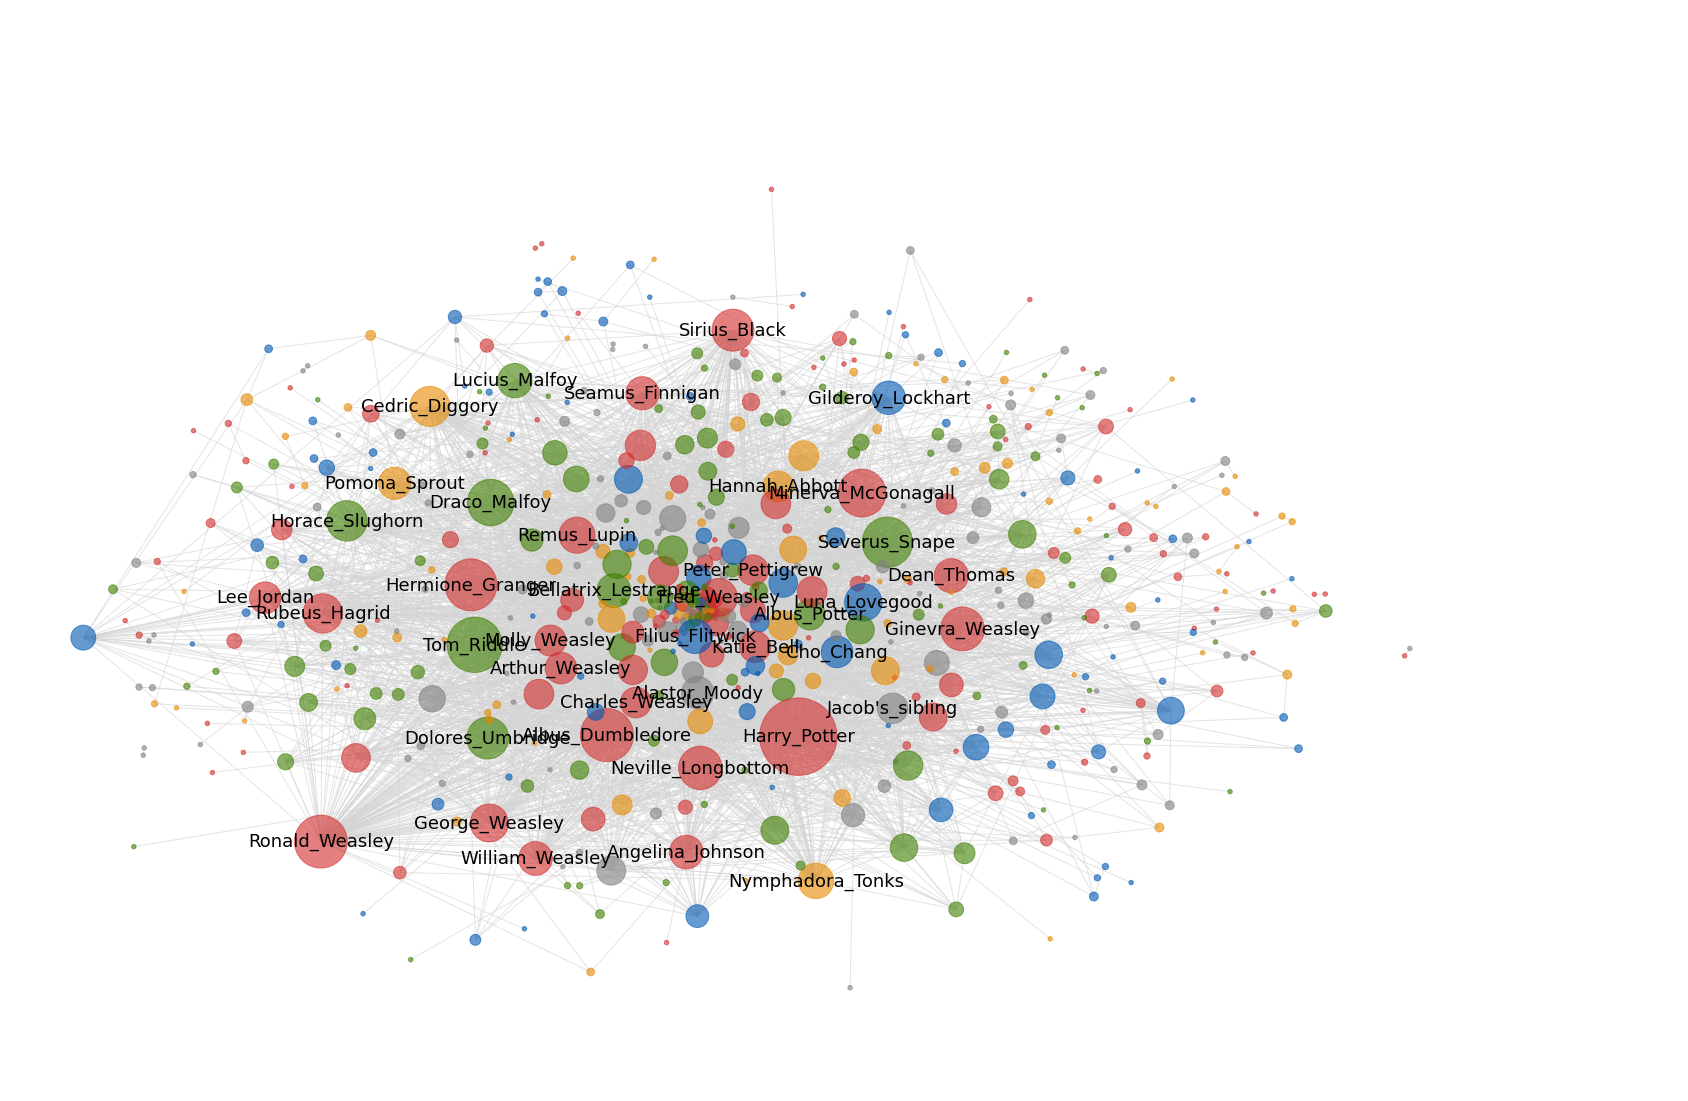

In [68]:
# visualization


# get the dict of degree in G undirected 
d = dict(G_Hogwarts_undirect.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:40]

# represent for Gryffindors, Hufflepuffs, Ravenclaws and Slytherins respectively (and also unknow ones)
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#808080']

# color map for nodes
color_map_nodes = []
for node in list(G_Hogwarts_undirect.nodes()):
    if nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Gryffindors':
        color_map_nodes.append(colors[0])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Hufflepuffs':
        color_map_nodes.append(colors[1])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Ravenclaws':
        color_map_nodes.append(colors[2])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Slytherins':
        color_map_nodes.append(colors[3])
    else:
        color_map_nodes.append(colors[4])
    
plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=1.2, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_Hogwarts_undirect, pos=None, iterations=100)
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()


In [69]:
# louvain_partition = community.best_partition(G, weight='weight')
partition = community_louvain.best_partition(G_Hogwarts_undirect,weight='weight')


In [70]:
par_class = set(partition.values())
par_class_dict = {}
for v in partition.values():
    str_v = str(v)
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [71]:
par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
print(par_sorted[:10])
selected_par = list(dict(par_sorted).keys())[:5]
print(selected_par)

[('0', 158), ('16', 79), ('20', 62), ('1', 56), ('3', 40), ('15', 22), ('7', 20), ('26', 19), ('33', 16), ('34', 12)]
['0', '16', '20', '1', '3']


In [72]:
community = {}
for par in selected_par:
    com_name = 'com_'+str(par)
    community[com_name] = []
community['other'] = []

for node in G_Hogwarts_undirect.nodes():
    if str(partition[node]) in selected_par:
        com_name = 'com_'+str(partition[node])
        community[com_name].append(node)
    else:
        community['other'].append(node)

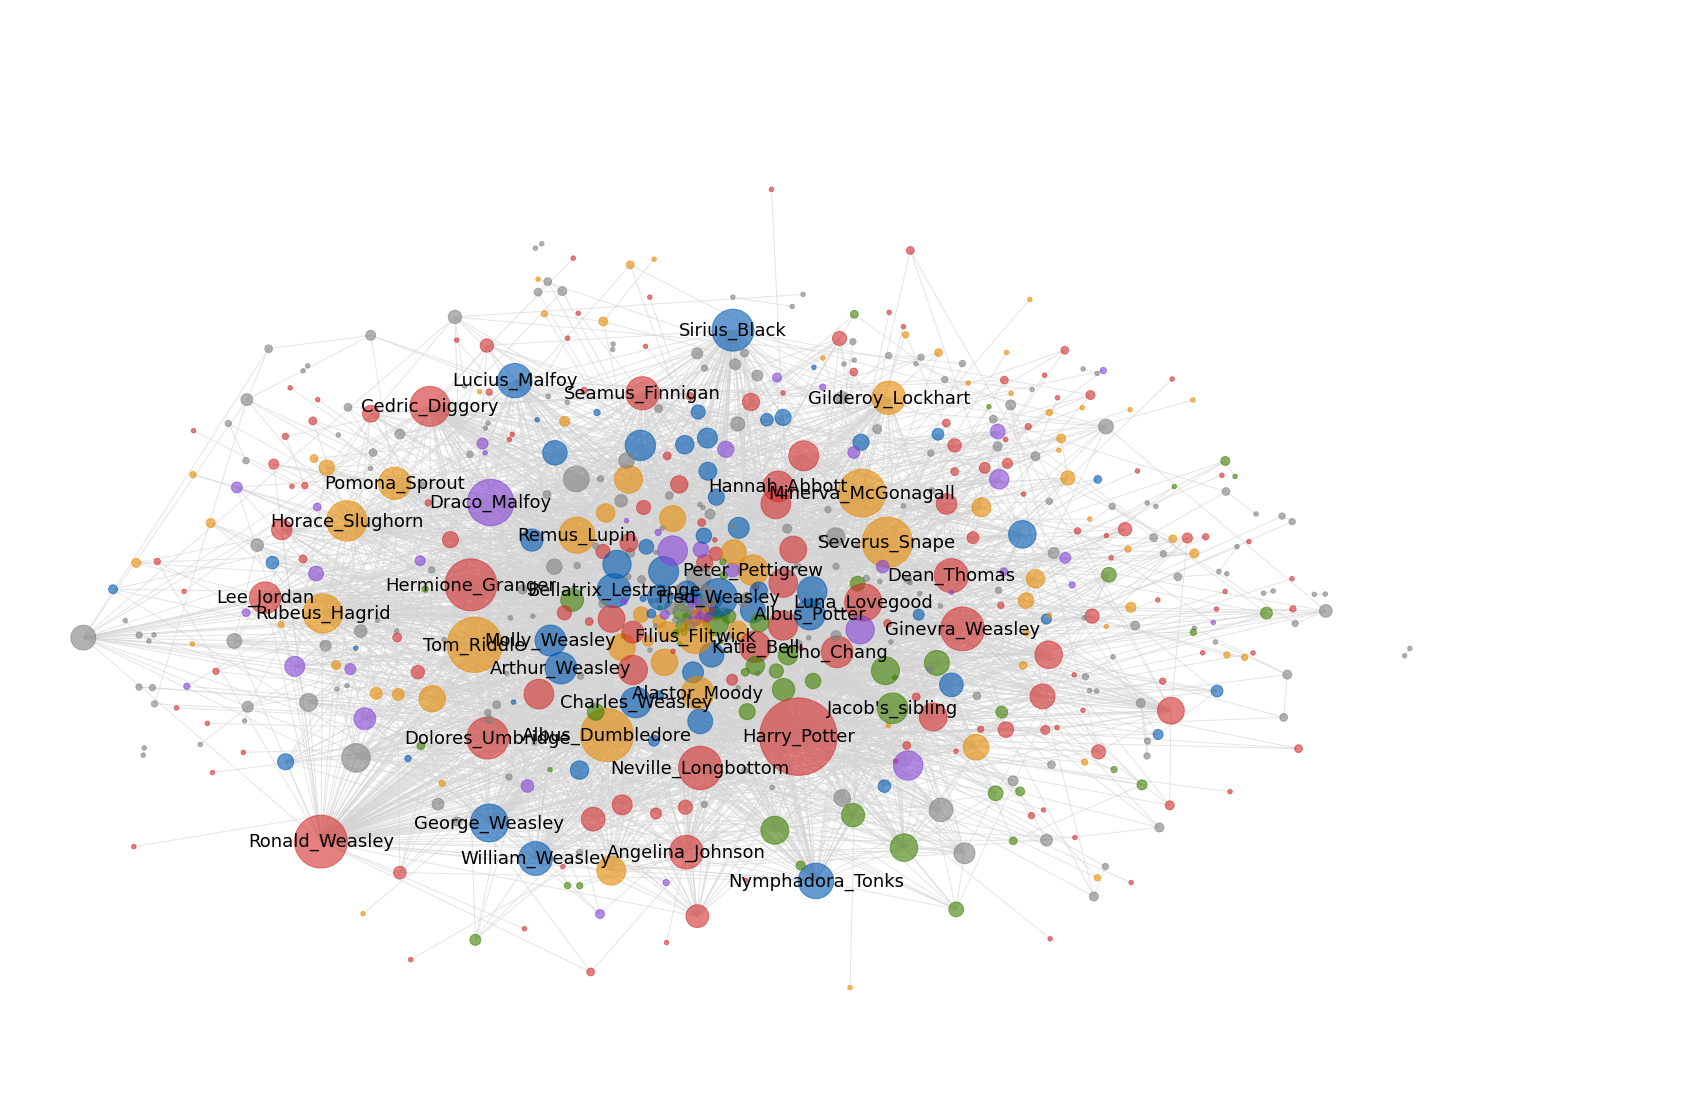

In [73]:
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G_Hogwarts_undirect.nodes()):
    if str(partition[node]) in selected_par:
        color = color_dict[str(partition[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)

plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()